<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/CASTOR_TLM_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jaxlib==0.4.14
!pip install jax==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

!pip install astropy pzflow corner

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

Mounted at /content/drive
698211
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.16+cuda11.cudnn86
    Uninstalling jaxlib-0.4.16+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.16+cuda11.cudnn86
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00


In [10]:
cd /content/drive/MyDrive/Research/CASTORpz


/content/drive/MyDrive/Research/CASTORpz


In [11]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

In [12]:
names_phot = ["ID", "photoz",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']



available_os = ["CASTOR-only", "LSST-only", "Euclid-only", #"Roman-only",
"LSST+CASTOR", "Euclid+CASTOR", #"Roman+CASTOR",
"Euclid+LSST", "Euclid+LSST+CASTOR"
]

Roman_os = ["Roman-only", "Roman+CASTOR", "Roman+Euclid+LSST+CASTOR", "Roman+LSST"]

available_os = available_os + Roman_os
print(available_os)

names = available_os

['CASTOR-only', 'LSST-only', 'Euclid-only', 'LSST+CASTOR', 'Euclid+CASTOR', 'Euclid+LSST', 'Euclid+LSST+CASTOR', 'Roman-only', 'Roman+CASTOR', 'Roman+Euclid+LSST+CASTOR', 'Roman+LSST']


In [13]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [14]:
# want to read in here the cleaned catalogs that have been saved elsewhere

In [15]:
ls

all_combos_histogram.pdf
all_combos_over_z.pdf
ext_phot.fits
Feb_ensembles/
knn_colors.py
losses_for_CASTOR-only.pkl
losses_for_Euclid+CASTOR.pkl
losses_for_Euclid+LSST+CASTOR.pkl
losses_for_Euclid+LSST.pkl
losses_for_Euclid-only.pkl
losses_for_LSST+CASTOR.pkl
losses_for_LSST-only.pkl
losses_for_Roman+CASTOR.pkl
losses_for_Roman+Euclid+LSST+CASTOR.pkl
losses_for_Roman+Euclid+LSST.pkl
losses_for_Roman+LSST.pkl
losses_for_Roman-only.pkl
May_flows/
Oct_flows/
Oct_flows_draft/
Oct_flows_draftpzflow_ensemble_for_CASTOR-only.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid+LSST.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid-only.pkl
Oct_flows_draftpzflow_ensemble_for_LSST+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_LSST-only.pkl
Oct_flows_draftpzflow_ensemble_for_Roman+Euclid+LSST+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_Roman+Euclid+LSST.pkl
Oct_flowspzflow_ensemble_for_CASTOR-only.pkl
Oct_flowspzflow_ensemble_for_Euclid+CASTOR.pkl
Oct

In [16]:
available_os = ['LSST-only',
                'CASTOR-only',
                'Euclid+LSST',
                'LSST+CASTOR',
                'Roman+Euclid+LSST',
                'Roman+Euclid+LSST+CASTOR']

# what I actually want is LSST + Roman
# and LSST + Roman + Euclid
# rerunning now

In [17]:
ls *.pkl

losses_for_CASTOR-only.pkl
losses_for_Euclid+CASTOR.pkl
losses_for_Euclid+LSST+CASTOR.pkl
losses_for_Euclid+LSST.pkl
losses_for_Euclid-only.pkl
losses_for_LSST+CASTOR.pkl
losses_for_LSST-only.pkl
losses_for_Roman+CASTOR.pkl
losses_for_Roman+Euclid+LSST+CASTOR.pkl
losses_for_Roman+Euclid+LSST.pkl
losses_for_Roman+LSST.pkl
losses_for_Roman-only.pkl
Oct_flows_draftpzflow_ensemble_for_CASTOR-only.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid+LSST.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid-only.pkl
Oct_flows_draftpzflow_ensemble_for_LSST+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_LSST-only.pkl
Oct_flows_draftpzflow_ensemble_for_Roman+Euclid+LSST+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_Roman+Euclid+LSST.pkl
Oct_flowspzflow_ensemble_for_CASTOR-only.pkl
Oct_flowspzflow_ensemble_for_Euclid+CASTOR.pkl
Oct_flowspzflow_ensemble_for_Euclid+LSST+CASTOR.pkl
Oct_flowspzflow_ensemble_for_Euclid+LSST.pkl
Oct_flowspzflow_ensemble_for_Euclid

In [18]:
flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"Oct_flows_draftpzflow_ensemble_for_{os}.pkl")

In [19]:
flows['LSST-only'].data_columns

['z_true']

In [20]:
grid = jnp.linspace(0, 4, 100)

pdfs = flows['LSST-only'].posterior(catalogs['LSST-only'], column="z_true", grid=grid)

NameError: ignored

In [ ]:
plt.plot(grid, pdfs[4])
plt.xlabel("$x$")
plt.ylabel("$p(x|y=0.78)$")
plt.show()

In [21]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')

In [22]:
CASTOR_baseline = Table.from_pandas(mock_cat[(mock_cat["Euclid_VIS_MAG"] <= 24.5) & (mock_cat["LSST_r_MAG"] >= 17.5)]) # apply magnitude limit cuts

In [23]:
# put data in expected format for TLM

LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# Roman - only a subset of the Roman filters are available?

# Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [24]:
# get magnitudes and set up the catalogs

catalogs = dict()
catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag
                      }).set_index('CASTOR_ID').dropna()

catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                              'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                              'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag,
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()

catalogs["Roman+Euclid+LSST+CASTOR"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag,
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag,
                             '106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag
                      }).set_index('CASTOR_ID').dropna()

catalogs["Roman+Euclid+LSST"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag,
                             '106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag
                      }).set_index('CASTOR_ID').dropna()

In [25]:
# available_os = ['LSST-only',
#                 'CASTOR-only',
#                 'Euclid+CASTOR',
#                 'LSST+CASTOR']
just_tav = {}
for os in available_os:
  just_tav[os] = flows[os].log_prob(catalogs[os])

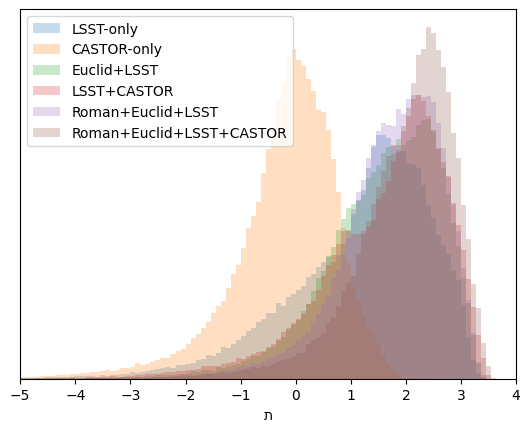

In [26]:
for os in available_os:
  plt.hist(just_tav[os], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
  plt.legend()
  plt.xlim(-5,4)
  plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  plt.yticks([])
plt.show()

In [27]:
worst_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[::-1][0:1000]
best_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[0:1000]

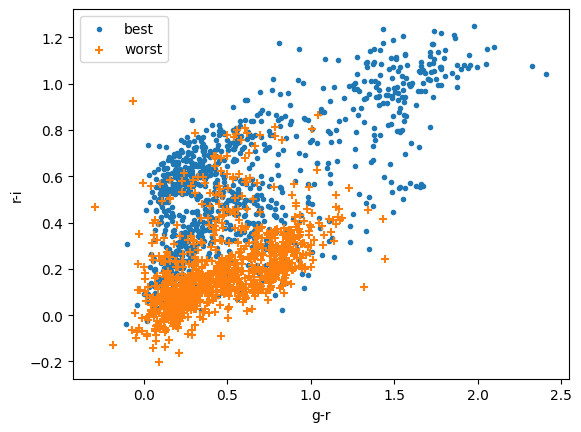

In [33]:
plt.scatter(np.array(catalogs['LSST+CASTOR']['g-r'])[best_galaxies], np.array(catalogs['LSST+CASTOR']['r-i'])[best_galaxies], label = 'best', marker = '.')
plt.scatter(np.array(catalogs['LSST+CASTOR']['g-r'])[worst_galaxies], np.array(catalogs['LSST+CASTOR']['r-i'])[worst_galaxies], label = 'worst', marker = '+')

plt.xlabel('g-r')
plt.ylabel('r-i')

plt.legend()

In [34]:
from sklearn import manifold

In [35]:
n_components = 2  # number of coordinates for the manifold

In [36]:
t_sne = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=0,
)

In [37]:
S_t_sne = t_sne.fit_transform(np.array(catalogs['LSST+CASTOR'].drop(labels = ['z_true', 'TLM_decile'], axis = 1))[best_galaxies])

KeyError: ignored

In [ ]:
x,y = S_t_sne.T

plt.scatter(x, y)

In [ ]:
colors = pd.qcut(flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR'])[best_galaxies], 10, labels = False) #change this to get deciles for the entire catalog and plot corresponding colors

In [ ]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)

In [ ]:
colors = np.array(catalogs['LSST+CASTOR']['TLM_decile'])[best_galaxies]

plot_2d(S_t_sne, colors, 'best galaxies colored by TLM decile')

In [ ]:
colors = pd.qcut(flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR']), 10, labels = False)

In [ ]:
catalogs['LSST+CASTOR']['TLM_decile'] = colors

In [ ]:
catalogs['LSST+CASTOR']

In [ ]:
flows['LSST+CASTOR'].items

In [38]:
import scipy.stats as sps
n=101
b = sps.mstats.mquantiles(z_true, np.linspace(0,1,n, endpoint=True))
# print(len(z_cats_no_nan[which_os]['z_true']))
# print(b)

b_centers = 0.5*(b[1:] + b[:-1])
db = b[1:] - b[:-1]

In [39]:
available_os = ['LSST-only',
 'Euclid+LSST',
 'Roman+Euclid+LSST',
 'Roman+Euclid+LSST+CASTOR']

# available_os = ['Euclid+LSST']

In [40]:
all_tlm = {}
all_milb = {}
all_ent = {}
is_inf_mask = {}

for os in available_os:
    # print(os_names[os])
    # load the photometric catalog for this os
    cat = catalogs[os]

  # Computing the entropy H(z)
    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy



  # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = flows[os].log_prob(cat, returnEnsemble=True, err_samples=10)# + entropy
    print(np.sum(np.isinf(milb)))
    print(np.sum(np.isnan(milb)))
    print(np.shape(milb[0,:]))
    # print(milb)
    all_milb[os] = np.array(milb)
    # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=1) + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    print(np.sum(np.isinf(all_tlm[os])))

<ipython-input-40-46eeceb1d563>:12: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(30,)
0


<ipython-input-40-46eeceb1d563>:12: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


1
0
(30,)
0


<ipython-input-40-46eeceb1d563>:12: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(30,)
0


<ipython-input-40-46eeceb1d563>:12: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(30,)
0


In [41]:
print(is_inf_mask['LSST-only'])

[False False False ... False False False]


In [43]:
# drop nonconverged flows here

zbins = np.linspace(0, 3, 100)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  plotran = np.empty_like(zbins)
  ploterr = np.empty_like(zbins)
  print(catalogs[os].columns)
  if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = all_tlm[os]
    print(catalogs[os].columns)
  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
    # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std

  print(len(plotran))
  avgtav[os] = plotran
  errtav[os] = ploterr

LSST-only
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'logprob'], dtype='object')
100
Euclid+LSST
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')


ValueError: ignored

In [ ]:
for os in available_os:
  catalogs[os] = catalogs[os][is_inf_mask[os]]

0
nan


ValueError: ignored

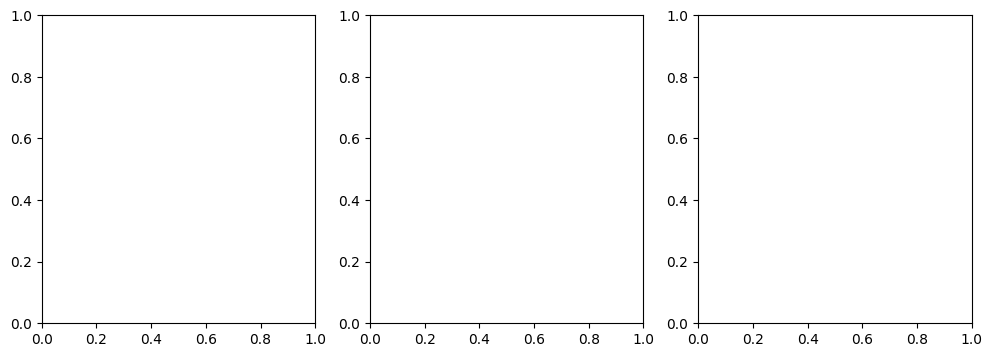

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for os in available_os:
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.5)
  ax[0].fill_between(zbins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
# plt.ylim(-10, 5)
ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z_true')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-1, 5)
# plt.savefig(prepend+'all_combos_over_z.pdf')


color_lim_min = np.min(catalogs['LSST+CASTOR']['g-r'])
color_lim_max = np.max(catalogs['LSST+CASTOR']['g-r'])

color_bins = np.linspace(color_lim_min, color_lim_max, 10)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['g-r'] >= color_min) & (catalogs['LSST+CASTOR']['g-r'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in available_os:
  ax[1].plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax[1].fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax[1].legend()
ax[1].set_xlabel('g-r')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-5, 5)
ax[1].set_xlim(-2, 5)


worst_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[::-1][0:1000]
# best_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST+CASTOR'])))[0:1000]

for os in available_os:
  plt.hist(just_tav[os][worst_galaxies], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
plt.legend()
plt.xlim(-5.2,4)
plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
plt.yticks([])

LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0


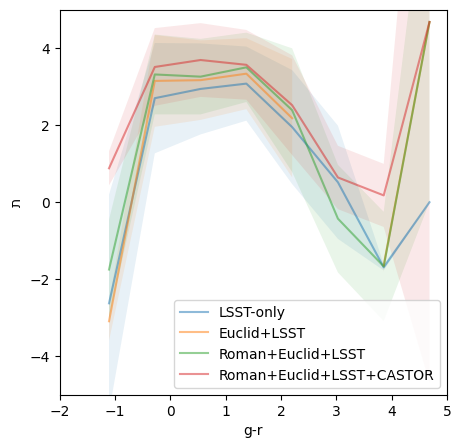

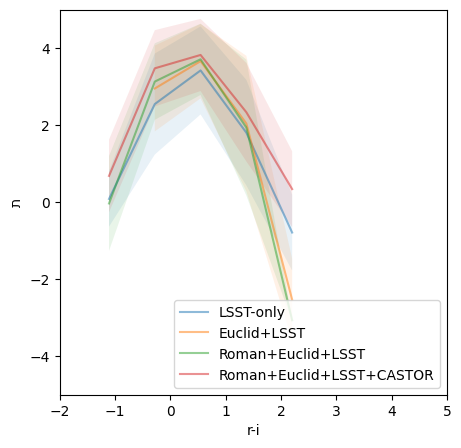

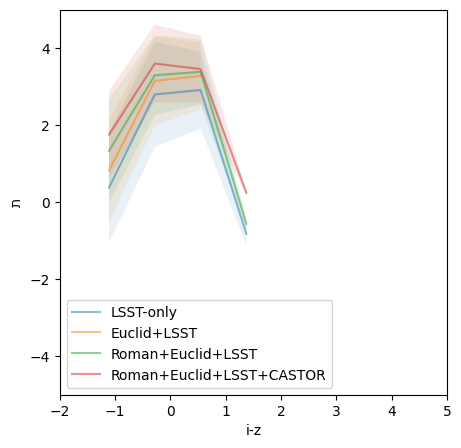

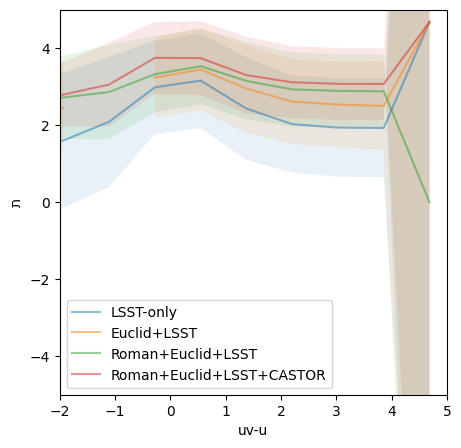

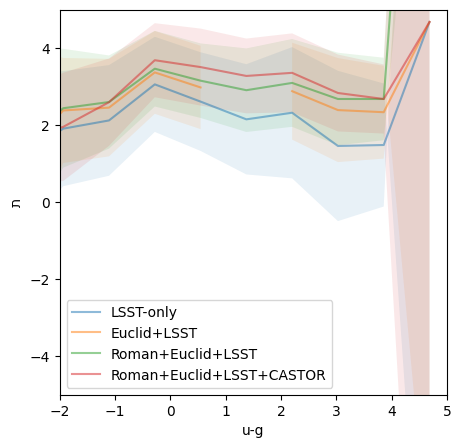

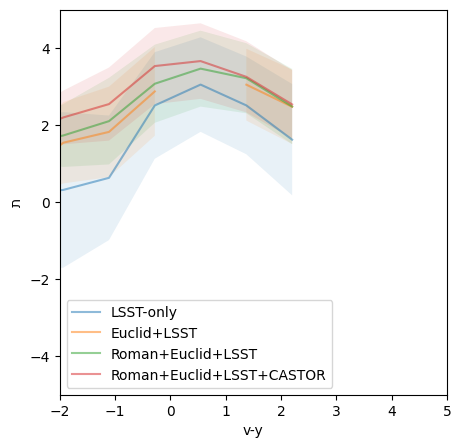

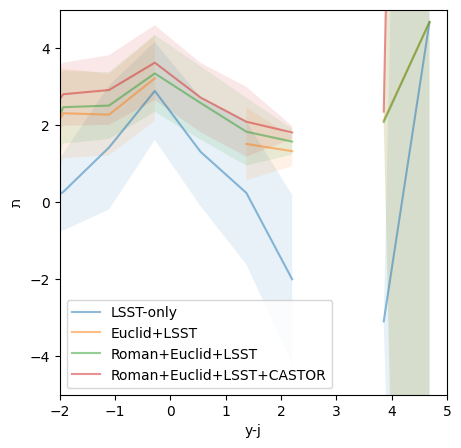

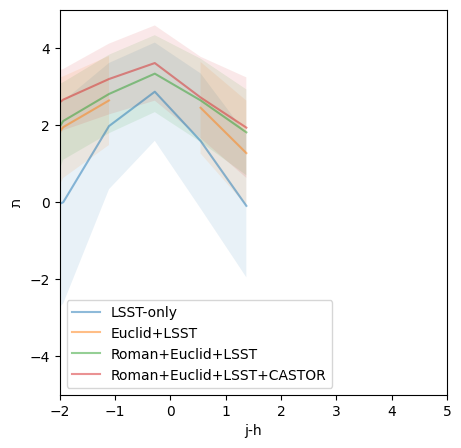

In [ ]:
colors = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'v-y', 'y-j', 'j-h']

for color in colors:

  fig, ax = plt.subplots(1, 1, figsize = (5, 5))

  for os in available_os:
    print(os)
    color_bins = np.linspace(color_lim_min, color_lim_max, 10)

    plotran = np.empty_like(color_bins)
    ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = all_tlm[os]
    print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
    for i, color_min in enumerate(color_bins[:-1]):
      color_max = color_bins[i+1]
      subset = catalogs[os][(catalogs["Roman+Euclid+LSST+CASTOR"][color] >= color_min) & (catalogs["Roman+Euclid+LSST+CASTOR"][color] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
      vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
      mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
      std = np.std(vals)
      plotran[i] = mean
      ploterr[i] = std
    avgtav[os] = plotran
    errtav[os] = ploterr

    ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
    ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
  ax.legend()
  ax.set_xlabel(color)
  ax.set_ylabel(chr(0x05ea))
  ax.set_ylim(-5, 5)
  ax.set_xlim(-2, 5)
plt.show()


LSST-only
1
CASTOR-only
0
Euclid+CASTOR
0
LSST+CASTOR
0


(-1.0, 1.5)

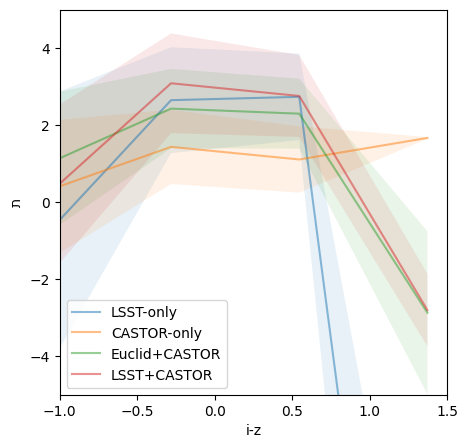

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))


for os in available_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['i-z'] >= color_min) & (catalogs['LSST+CASTOR']['i-z'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in available_os:
  ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax.legend()
ax.set_xlabel('i-z')
ax.set_ylabel(chr(0x05ea))
ax.set_ylim(-5, 5)
ax.set_xlim(-1, 1.5)

LSST-only
1
CASTOR-only
0
Euclid+CASTOR
0
LSST+CASTOR
0


(-1.0, 1.5)

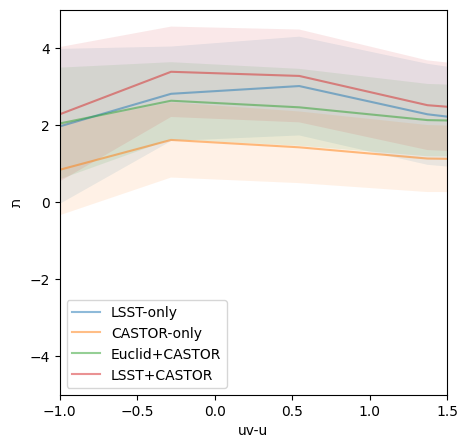

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))


for os in available_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['uv-u'] >= color_min) & (catalogs['LSST+CASTOR']['uv-u'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in available_os:
  ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax.legend()
ax.set_xlabel('uv-u')
ax.set_ylabel(chr(0x05ea))
ax.set_ylim(-5, 5)
ax.set_xlim(-1, 1.5)

LSST-only
1
CASTOR-only
0
Euclid+CASTOR
0
LSST+CASTOR
0


(-1.0, 1.5)

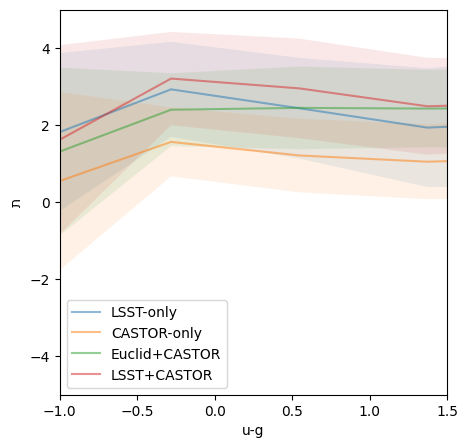

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))


for os in available_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['u-g'] >= color_min) & (catalogs['LSST+CASTOR']['u-g'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in available_os:
  ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax.legend()
ax.set_xlabel('u-g')
ax.set_ylabel(chr(0x05ea))
ax.set_ylim(-5, 5)
ax.set_xlim(-1, 1.5)

In [ ]:
catalogs['LSST+CASTOR']

,z_true,r,g-r,r-i,i-z,uv-u,u-g,TLM_decile,logprob
CASTOR_ID,,,,,,,,,
3,0.2211,23.259175,0.233539,0.022705,-0.005428,-0.081215,0.354974,7,3.981258
12,0.7070,24.580852,0.256711,0.638455,0.055040,0.274217,0.072682,0,1.105734
73,0.4290,22.664345,0.849034,0.207854,0.116569,0.540868,0.443804,3,2.688282
74,1.5087,23.744620,0.068058,0.050240,-0.009388,1.503954,0.277857,3,2.688986
85,1.0800,24.119466,0.139313,0.230962,0.423380,0.846885,0.173584,5,3.480589
...,...,...,...,...,...,...,...,...,...
964424,0.3275,20.315891,1.310021,0.486272,0.266220,-0.169152,2.147752,4,3.077720
964426,0.3230,23.775628,0.738462,0.247866,0.226397,0.701451,0.693045,6,3.628557
964427,1.4726,25.507346,2.642820,2.072411,0.918244,-0.684684,2.263595,0,-1.256718


In [44]:
test_tav = {}
for os in available_os:
  test_tav[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

In [53]:
for os in available_os:
  print(np.sum(pd.DataFrame(np.isnan(test_tav[os]))))

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
dtype: int64
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
dtype: int64
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
dtype: int64
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
d

In [107]:
losses = {}
for os in available_os:
  with (open(f"losses_for_{os}.pkl", 'rb')) as openfile:
    losses[os] = pd.read_pickle(openfile)

In [155]:
flow_list = list(np.linspace(0, 29, 30).astype(int))
bad_flows = {}

for os in available_os:
  bad_flows_list = []
  for flow in flow_list:
    if np.sum(np.isinf(np.array(losses[os]['losses'][f"Flow {flow}"]))) > 0:
      bad_flows_list.append(flow)
    bad_flows[os] = bad_flows_list

In [156]:
bad_flows

{'LSST-only': [8, 17, 20],
 'Euclid+LSST': [2, 8, 9, 13],
 'Roman+Euclid+LSST': [2, 5, 14, 16, 19],
 'Roman+Euclid+LSST+CASTOR': [7, 15]}

In [132]:
flow_list

[0,
 0,
 1,
 1,
 2,
 2,
 3,
 4,
 4,
 5,
 5,
 6,
 7,
 7,
 8,
 8,
 9,
 10,
 10,
 11,
 11,
 12,
 13,
 13,
 14,
 14,
 15,
 15,
 16,
 17,
 17,
 18,
 18,
 19,
 20,
 20,
 21,
 21,
 22,
 23,
 23,
 24,
 24,
 25,
 26,
 26,
 27,
 27,
 28,
 29]

In [145]:
list(np.linspace(0, 29, 30).astype(int))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]